In [1]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import seaborn as sns
import json

data_path = 'data/'
fig_path = 'figures/'

In [2]:
###### IO TABLE
from data_manipulation import data_manipulation 

data = pd.read_csv(data_path + 'data_FIGARO2019.csv')
data.index = data['rowLabels']
data.drop(columns = data.columns[0], axis = 1, inplace = True)
data = data.drop(data.index[data.index.str.contains('_U')]) # drop all rows _U
data = data.drop(data.columns[data.columns.str.contains('_U')], axis = 1) # drop all columns _U
country = 'BE' # choose country with corresponding abbreviation

data_bel = data_manipulation(country, data)
# data_bel._fields = ('Z', 'A', 'L', 'f', 'x', 'Z_imp')

In [3]:
###### SHOCK ESTIMATES (based on del Rio-Chanona et al. (2020), Pichler and Farmer (2021) and CBO study (2006))
###### (--> adjustments were made to ESS in general and to RLI for the breakdown of N, Q, R & S into different parts)  
from shock_derivation import shocks

## read shockdata 
shocks_raw = pd.read_csv(data_path + 'shock_data_Belgium.csv')[:-1]
# remote labor index of T equal to 1 instead of NA
shocks_raw['remote_labor_index'] = shocks_raw['remote_labor_index'].replace([shocks_raw['remote_labor_index'][62]], 1)

shocks_raw['demand_shock_household'] = shocks_raw['demand_shock_household']*(-1)

shocks = shocks(shocks_raw = shocks_raw)
# shocks._fields = ('shocks_raw', 'supply_shocks_bel', 'demand_shocks_consumption', 
# 'demand_shocks_invest', 'demand_shocks_export')

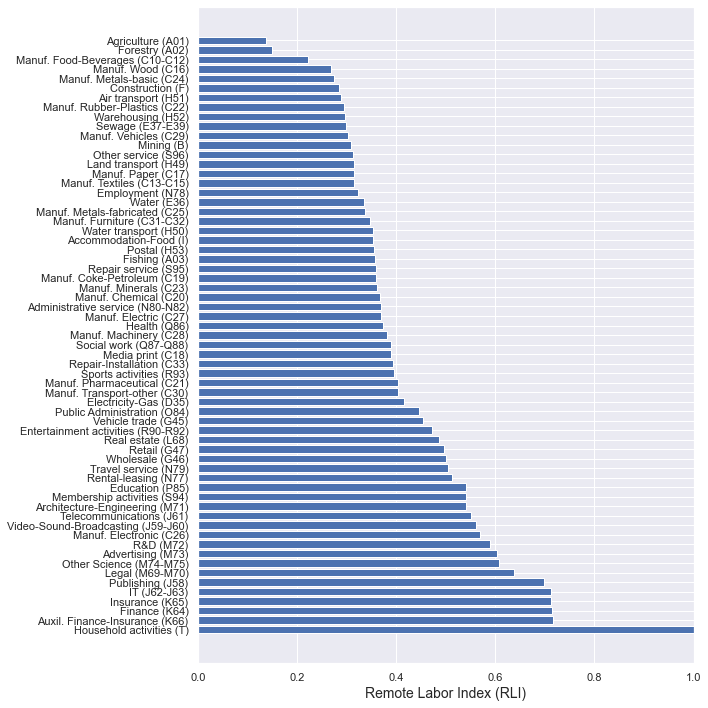

In [7]:
###### PLOT: RLI for industries (fig 4.2)
sns.set_theme()

shocks_raw_ordered_RLI = shocks_raw.sort_values(by='remote_labor_index', ascending=True)

# Get a new column with the following values: 'Agriculture (A01)', ...
def combine_columns(row):
    return f'{row["FIGARO_short"]} ({row["FIGARO_code"]})'
shocks_raw_ordered_RLI['Combined'] = shocks_raw_ordered_RLI.apply(combine_columns, axis=1)

# PLOT
fig, ax = plt.subplots(figsize=(10,10))
y_pos1 = np.arange(len(shocks_raw_ordered_RLI))
ax.barh(y_pos1, shocks_raw_ordered_RLI['remote_labor_index'], align='center')
ax.set_yticks(y_pos1, labels=shocks_raw_ordered_RLI['Combined'], fontsize=11)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Remote Labor Index (RLI)', fontsize=14)
ax.set_xlim([0, 1])

plt.tight_layout()

plt.savefig(fig_path + 'RLI.png', bbox_inches='tight')

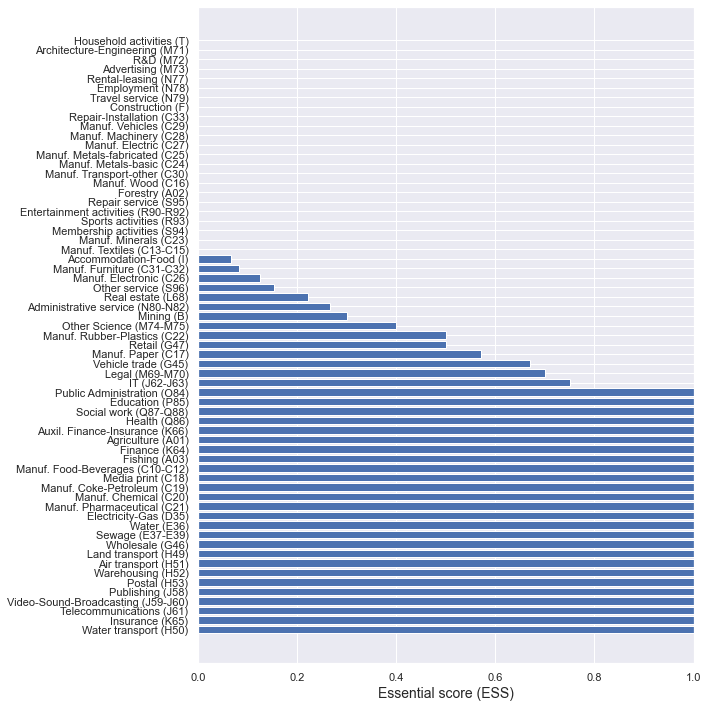

In [120]:
###### PLOT: ESS for industries (fig 4.3)
sns.set_theme()

shocks_raw_ordered_ESS = shocks_raw.sort_values(by='essential_score_BE', ascending=True)

# Get a new column with the following values: 'Agriculture (A01)', ...
def combine_columns(row):
    return f'{row["FIGARO_short"]} ({row["FIGARO_code"]})'
shocks_raw_ordered_ESS['Combined'] = shocks_raw_ordered_ESS.apply(combine_columns, axis=1)

# PLOT
fig, ax = plt.subplots(figsize=(10,10))
y_pos1 = np.arange(len(shocks_raw_ordered_ESS))
ax.barh(y_pos1, shocks_raw_ordered_ESS['essential_score_BE'], align='center')
ax.set_yticks(y_pos1, labels=shocks_raw_ordered_ESS['Combined'], fontsize=11)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Essential score (ESS)', fontsize=14)
ax.set_xlim([0, 1])

plt.tight_layout()

plt.savefig(fig_path + 'ESS.png', bbox_inches='tight')

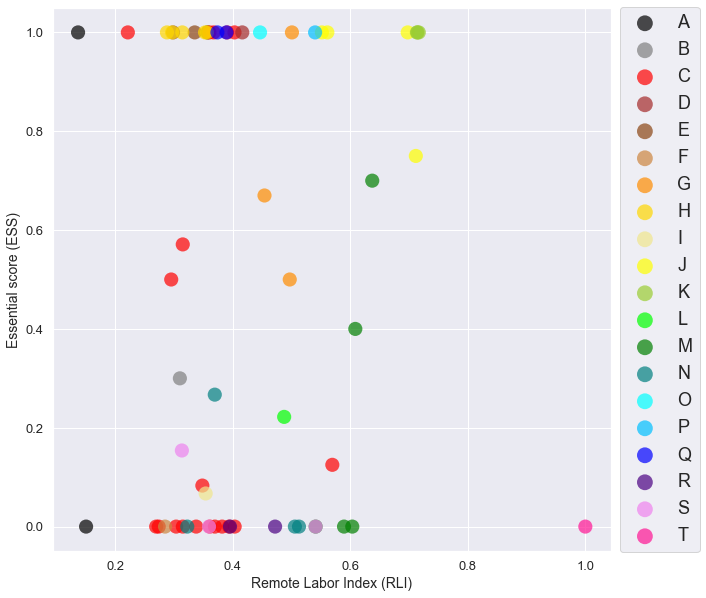

In [8]:
###### PLOT: RLI vs ESS for industries (fig 4.4)
sns.set_theme()

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('Remote Labor Index (RLI)', fontsize=14)
ax.set_ylabel('Essential score (ESS)', fontsize=14)
ax.tick_params(labelsize=13)

## Assign a color to each sector (based on first letter)
first_letters = pd.DataFrame(shocks_raw['FIGARO_code'].str[0])['FIGARO_code']
colors = ['black', 'gray', 'red', 'brown', 'saddlebrown', 'peru', 'darkorange', 
           'gold', 'khaki', 'yellow', 'yellowgreen', 'lime', 'green', 'teal',
          'aqua', 'deepskyblue', 'blue', 'indigo', 'violet', 'deeppink']
color_map = dict(zip(sorted(first_letters.unique()), colors))

## drawing the scatterplot
for letter in first_letters.unique():
    x = shocks_raw['remote_labor_index'][shocks_raw['FIGARO_code'].str.contains(letter)]
    y = shocks_raw['essential_score_BE'][shocks_raw['FIGARO_code'].str.contains(letter)]
    color = color_map[letter]
    label = letter
    scale = 200
    ax.scatter(x, y, c=color, label=label, s = scale,
               alpha=0.7, edgecolors='none')
    
## add legend
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 18})
# fix size of dots in legend
for handle in lgnd.legendHandles:
    handle.set_sizes([250])

plt.savefig(fig_path + 'RLIvsESS.png', bbox_inches='tight')

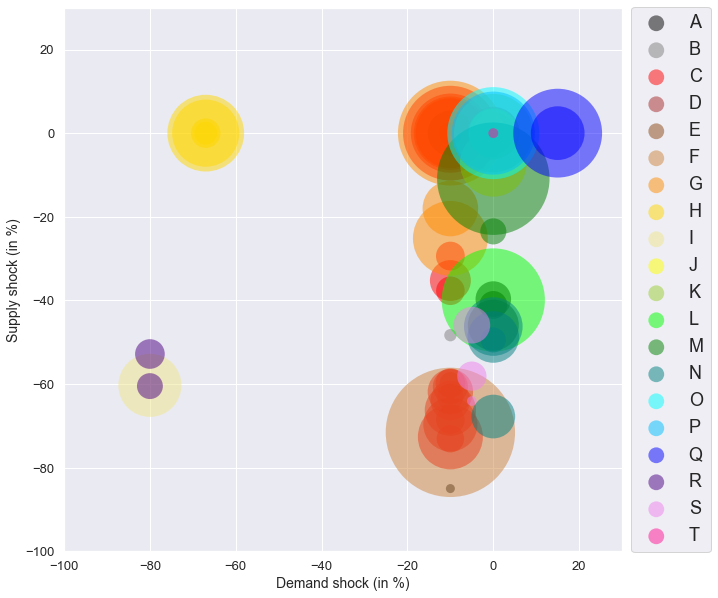

In [10]:
###### PLOT: supply vs demand shocks for industries (fig 4.5)
sns.set_theme()

fig, ax = plt.subplots(figsize=(10,10))

ax.set_ylabel('Supply shock (in %)', fontsize=14)
ax.set_xlabel('Demand shock (in %)', fontsize=14)
ax.set_xlim([-100, 30])
ax.set_ylim([-100, 30])
ax.tick_params(labelsize=13)

## Assign a color to each sector (based on first letter)
first_letters = pd.DataFrame(shocks_raw['FIGARO_code'].str[0])['FIGARO_code']
colors = ['black', 'gray', 'red', 'brown', 'saddlebrown', 'peru', 'darkorange', 
           'gold', 'khaki', 'yellow', 'yellowgreen', 'lime', 'green', 'teal',
          'aqua', 'deepskyblue', 'blue', 'indigo', 'violet', 'deeppink']
color_map = dict(zip(sorted(first_letters.unique()), colors))

## drawing the scatterplot
for letter in first_letters.unique():
    x = -shocks.demand_shocks_consumption[shocks_raw['FIGARO_code'].str.contains(letter)]*100 # in percentage
    y = -shocks.supply_shocks_bel[shocks_raw['FIGARO_code'].str.contains(letter)]*100 # in percentage
    color = color_map[letter]
    label = letter
    scale = 0.2*data_bel.x[data_bel.x.index.str.contains('_' + letter)].squeeze() # size of dots represents GO (x)
    ax.scatter(x, y, c=color, label=label, s = scale,
               alpha=0.5, edgecolors='none')
    
## add legend
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 18})
# fix size of dots in legend
for handle in lgnd.legendHandles:
    handle.set_sizes([250])
    
plt.savefig(fig_path + 'supply_vs_demand.png', bbox_inches='tight')

In [4]:
###### MODEL INITIALIZATION: boundary values xmax & fmax (and xmin & fmin)
from model_initialization import model
constraints  = model(x = data_bel.x, f = data_bel.f, supply_shock = shocks.supply_shocks_bel,
                    demand_shocks_consumption = shocks.demand_shocks_consumption, 
                    demand_shocks_invest = shocks.demand_shocks_invest, 
                    demand_shocks_export = shocks.demand_shocks_export)
# constraints._fields ('xmax', 'xmin', 'fmax', 'fmin', 'c')

In [5]:
###### OPTIMIZATION BASED IO MODEL 
from optimization_functions import maxF, maxX, LP

optimization = LP(x = data_bel.x, f = data_bel.f, A = data_bel.A, L = data_bel.L,
                xmax = constraints.xmax, fmax = constraints.fmax)
#optimization._fields('xvalues', 'fvalues')

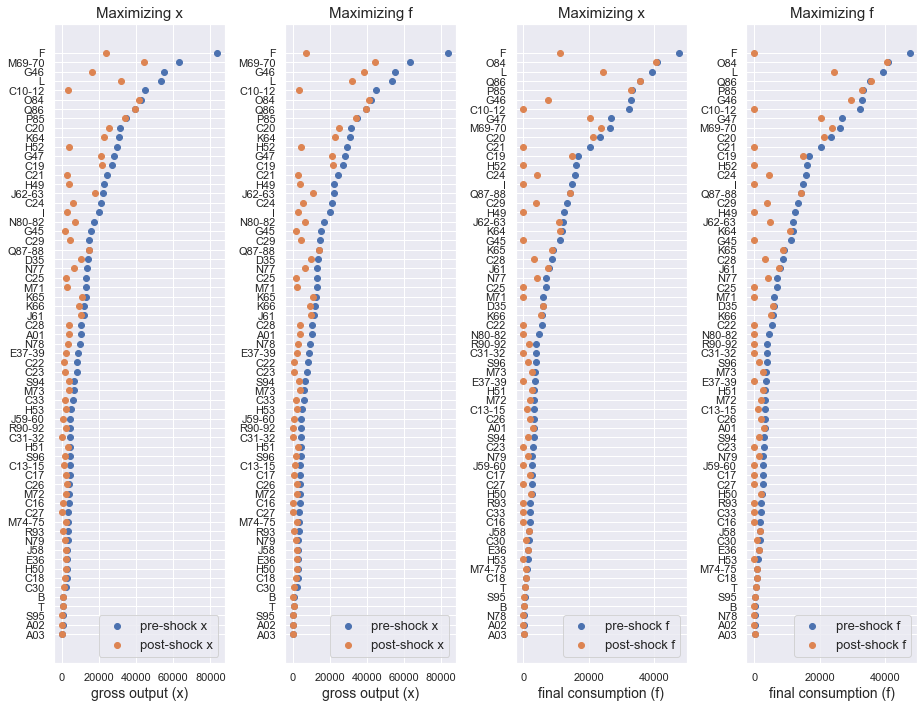

In [10]:
###### PLOT: optimization results (fig 5.1)
sns.set_theme()

data_bel_x_ordered = data_bel.x.sort_values(ascending=False) 
data_bel_f_ordered = data_bel.f.sum(axis=1).sort_values(ascending=False)

## PLOT
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 10))

## ax1: max X: gross output (x)
y_pos1 = np.arange(len(data_bel_x_ordered))
ax1.scatter(data_bel_x_ordered, y_pos1, label = 'pre-shock x') # initial values for x
# labels 
labels_x = [0] * len(data_bel_x_ordered)
for i in range(0, len(data_bel_x_ordered)):
    labels_x[i] = data_bel_x_ordered.index[i][3:]

ax1.set_yticks(y_pos1, labels=pd.Series(labels_x), fontsize=11)
ax1.tick_params(labelsize=11)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('gross output (x)', fontsize=14) 
# add optimization results for x (maxX.x) + same order as data_bel_x_ordered
ax1.scatter(optimization.xvalues['x.maxX'].reindex(data_bel_x_ordered.index), y_pos1, label = 'post-shock x') 
ax1.legend(loc='lower right', fontsize=13)
ax1.set_title('Maximizing x', fontsize=15)


## ax2: max F: gross output (x)
y_pos2 = np.arange(len(data_bel_x_ordered))
ax2.scatter(data_bel_x_ordered, y_pos2, label = 'pre-shock x') # initial values for x
# labels 
labels_x = [0] * len(data_bel_x_ordered)
for i in range(0, len(data_bel_x_ordered)):
    labels_x[i] = data_bel_x_ordered.index[i][3:]

ax2.set_yticks(y_pos2, labels=pd.Series(labels_x), fontsize=11)
ax2.tick_params(labelsize=11)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('gross output (x)', fontsize=14) 
# add optimization results for x (maxF.x) + same order as data_bel_x_ordered
ax2.scatter(optimization.xvalues['x.maxF'].reindex(data_bel_x_ordered.index), y_pos2, label = 'post-shock x') 
ax2.legend(loc = 'lower right', fontsize=13)
ax2.set_title('Maximizing f', fontsize = 15)


## ax3: max X: final consumption (f)
y_pos3 = np.arange(len(data_bel_f_ordered))
ax3.scatter(data_bel_f_ordered, y_pos3, label = 'pre-shock f') # initial values for f 
# labels 
labels_f = [0] * len(data_bel_f_ordered)
for i in range(0, len(data_bel_f_ordered)):
    labels_f[i] = data_bel_f_ordered.index[i][3:]

ax3.set_yticks(y_pos3, labels=pd.Series(labels_f), fontsize=11)
ax3.tick_params(labelsize=11)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_xlabel('final consumption (f)', fontsize=14)
# add optimization results for f (maxX.f) + same order as data_bel_f_ordered
ax3.scatter(optimization.fvalues['f.maxX'].reindex(data_bel_f_ordered.index), y_pos3, label = 'post-shock f') 
ax3.legend(loc='lower right', fontsize=13)
ax3.set_title('Maximizing x', fontsize = 15)


## ax4: max F: final consumption(f)
y_pos4 = np.arange(len(data_bel_f_ordered))
ax4.scatter(data_bel_f_ordered, y_pos4, label='pre-shock f') # initial values for f
# labels 
labels_f = [0] * len(data_bel_f_ordered)
for i in range(0, len(data_bel_f_ordered)):
    labels_f[i] = data_bel_f_ordered.index[i][3:]

ax4.set_yticks(y_pos4, labels=pd.Series(labels_f), fontsize=11)
ax4.tick_params(labelsize=11)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_xlabel('final consumption (f)', fontsize=14)
# add optimization results for f (maxF.f) + same order as data_bel_f_ordered
ax4.scatter(optimization.fvalues['f.maxF'].reindex(data_bel_f_ordered.index), y_pos4, label = 'post-shock f') 
ax4.legend(loc = 'lower right', fontsize=13)
ax4.set_title('Maximizing f', fontsize = 15)


plt.tight_layout()
plt.savefig(fig_path + 'LP_combined.png', bbox_inches='tight')


In [56]:
###### TABLE: total pre- and post-shock values for x and f for the optimization based IO model

print('gross output (x)')
print('x ', optimization.xvalues['x'].sum(axis=0))
print('x_maxX ', optimization.xvalues['x.maxX'].sum(axis=0))
print('x_maxF ', optimization.xvalues['x.maxF'].sum(axis=0))
print('---------------')
print('final consumption (f)')
print('f ', optimization.fvalues['f'].sum(axis=0))
print('f_maxX ', optimization.fvalues['f.maxX'].sum(axis=0))
print('f_maxF ', optimization.fvalues['f.maxF'].sum(axis=0))
print('---------------')


gross output (x)
x  974820.135000002
x_maxX  500763.4261480616
x_maxF  492586.9790463962
---------------
final consumption (f)
f  634473.5760000002
f_maxX  342059.052371234
f_maxF  343719.37608377606
---------------


In [11]:
###### RATIONING VARIATIONS
from rationing_functions import algo_prop, algo_ordered

## proportional rationing
strict_prop_bel = algo_prop(A = data_bel.A.iloc[:-1,:-1], L = data_bel.L.iloc[:-1,:-1], 
                            f = constraints.fmax[:-1], xmax = constraints.xmax[:-1], 
                            prioritize='no', TT=50)
# strict_prop_bel._fields = ('d', 'f', 'i', 'r', 's')

## mixed prop/prior rationing
mixed_prop_prior_bel = algo_prop(A = data_bel.A.iloc[:-1,:-1], L = data_bel.L.iloc[:-1,:-1], 
                                f = constraints.fmax[:-1], xmax = constraints.xmax[:-1], 
                                prioritize='firms', TT=50)
# mixed_prop_prior_bel._fields = ('d', 'f', 'i', 'r', 's')

## priority rationing (largest first)
prior_bel = algo_ordered(A = data_bel.A.iloc[:-1,:-1], L = data_bel.L.iloc[:-1,:-1], 
                        f = constraints.fmax[:-1], xmax = constraints.xmax[:-1], 
                        ordering ='priority', TT=50)
# prior_bel._fields = ('d', 'f', 'i', 's')

## random rationing (first-come-first-serve) (takes a while)
RUNS = 100
random_bel = [None] * RUNS
for k in range(RUNS):
    random_bel[k] = algo_ordered(A = data_bel.A.iloc[:-1,:-1], L = data_bel.L.iloc[:-1,:-1], 
                           f = constraints.fmax[:-1], xmax = constraints.xmax[:-1], 
                           ordering='random', TT=50)
# random_bel._fields = ('d', 'f', 'i', 's')


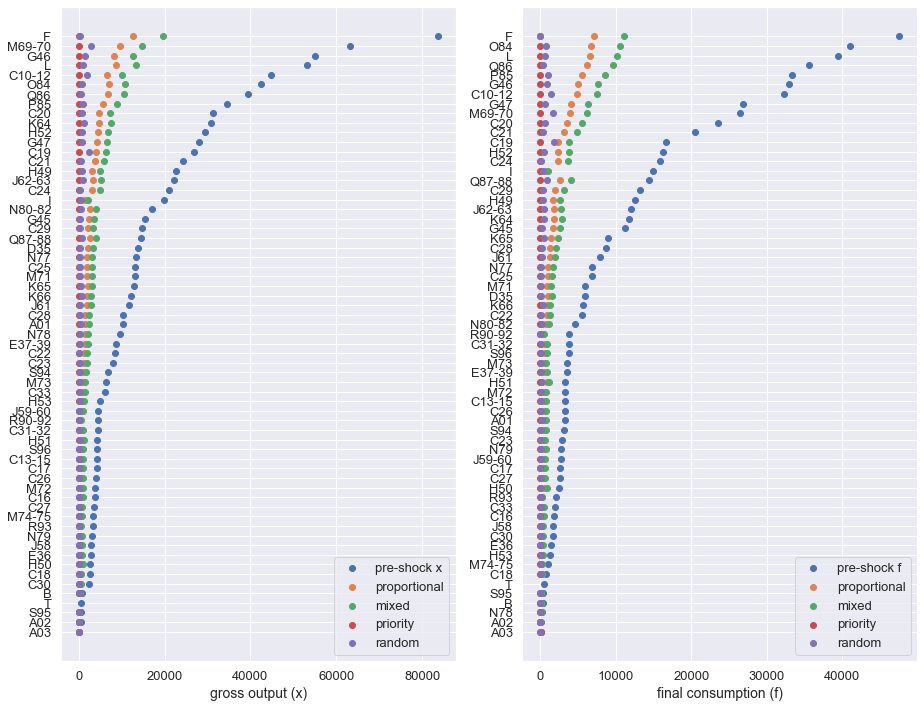

In [12]:
###### PLOT: rationing results (fig 5.2)
sns.set_theme()

data_bel_x_ordered = data_bel.x.sort_values(ascending=False) 
data_bel_f_ordered = data_bel.f.sum(axis=1).sort_values(ascending=False)

## PLOT
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,10))

## gross output (ax1)
y_pos1 = np.arange(len(data_bel_x_ordered))
# pre-shock (initial value)
ax1.scatter(data_bel_x_ordered, y_pos1, label = 'pre-shock x')
# labels 
labels_x = [0] * len(data_bel_x_ordered)
for i in range(0, len(data_bel_x_ordered)):
    labels_x[i] = data_bel_x_ordered.index[i][3:]

ax1.set_yticks(y_pos1, labels=pd.Series(labels_x), fontsize=13)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('gross output (x)', fontsize=14) 
ax1.tick_params(labelsize=13)

# proportional
strict_prop_bel_final_d = strict_prop_bel.d.iloc[:,-1:]
strict_prop_bel_final_d.index = data_bel.x.index[:-1]
ax1.scatter(strict_prop_bel_final_d.reindex(data_bel_x_ordered.index), y_pos1, label = 'proportional') 

# mixed
mixed_prop_prior_bel_final_d = mixed_prop_prior_bel.d.iloc[:,-1:]
mixed_prop_prior_bel_final_d.index = data_bel.x.index[:-1]
ax1.scatter(mixed_prop_prior_bel_final_d.reindex(data_bel_x_ordered.index), y_pos1, label = 'mixed')

# priority
prior_bel_final_d = prior_bel.d.iloc[:,-1:]
prior_bel_final_d.index = data_bel.x.index[:-1]
ax1.scatter(prior_bel_final_d.reindex(data_bel_x_ordered.index), y_pos1, label = 'priority') 

# random
random_bel_final_d = [None] * len(random_bel)
for i in range(len(random_bel)):
    random_bel_final_d[i] = random_bel[i].d.iloc[:,-1:]
# mean of the 100 random_bel.d dataframes for each industry
random_bel_final_d = pd.concat([random_bel_final_d[i] for i in range(len(random_bel))], axis=1).sum(axis=1)/len(random_bel)
random_bel_final_d.index = data_bel.x.index[:-1]
ax1.scatter(random_bel_final_d.reindex(data_bel_x_ordered.index), y_pos1, label = 'random') 

ax1.legend(loc='lower right', fontsize=13)

## final consumption (ax2)
y_pos2 = np.arange(len(data_bel_f_ordered))
# pre-shock (initial value)
ax2.scatter(data_bel_f_ordered, y_pos2, label = 'pre-shock f')
# labels 
labels_f = [0] * len(data_bel_f_ordered)
for i in range(0, len(data_bel_f_ordered)):
    labels_f[i] = data_bel_f_ordered.index[i][3:]

ax2.set_yticks(y_pos2, labels=pd.Series(labels_f), fontsize=13)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('final consumption (f)', fontsize=14)
ax2.tick_params(labelsize=13)

# proportional
strict_prop_bel_final_f = strict_prop_bel.f.iloc[:,-1:]
strict_prop_bel_final_f.index = data_bel.f.index[:-1]
ax2.scatter(strict_prop_bel_final_f.reindex(data_bel_f_ordered.index), y_pos2, label = 'proportional') 

# mixed
mixed_prop_prior_bel_final_f = mixed_prop_prior_bel.f.iloc[:,-1:]
mixed_prop_prior_bel_final_f.index = data_bel.f.index[:-1]
ax2.scatter(mixed_prop_prior_bel_final_f.reindex(data_bel_f_ordered.index), y_pos2, label = 'mixed')

# priority
prior_bel_final_f = prior_bel.f.iloc[:,-1:]
prior_bel_final_f.index = data_bel.f.index[:-1]
ax2.scatter(prior_bel_final_f.reindex(data_bel_f_ordered.index), y_pos2, label = 'priority') 

# random
random_bel_final_f = [None] * len(random_bel)
for i in range(len(random_bel)):
    random_bel_final_f[i] = random_bel[i].f.iloc[:,-1:]
# mean of the 100 random_bel.f dataframes for each industry
random_bel_final_f = pd.concat([random_bel_final_f[i] for i in range(len(random_bel))], axis=1).sum(axis=1)/len(random_bel)
random_bel_final_f.index = data_bel.f.index[:-1]
ax2.scatter(random_bel_final_f.reindex(data_bel_f_ordered.index), y_pos2, label = 'random') 

ax2.legend(loc='lower right', fontsize=13)


plt.tight_layout()

plt.savefig(fig_path + 'rationing_combined.png', bbox_inches='tight')


In [128]:
###### TABLE: total pre- and post-shock values for x and f for the different rationing variations

print('gross output (x)')
print('x ', optimization.xvalues['x'].sum(axis=0))
print('proportional ', strict_prop_bel_final_d.sum(axis=0)[0])
print('mixed ', mixed_prop_prior_bel_final_d.sum(axis=0)[0])
print('priority ', prior_bel_final_d.sum(axis=0)[0])
print('random ', random_bel_final_d.sum(axis=0))
print('---------------')
print('final consumption (f)')
print('f ', optimization.fvalues['f'].sum(axis=0))
print('proportional ', strict_prop_bel_final_f.sum(axis=0)[0])
print('mixed ', mixed_prop_prior_bel_final_f.sum(axis=0)[0])
print('priority ', prior_bel_final_f.sum(axis=0)[0])
print('random ', random_bel_final_f.sum(axis=0))
print('---------------')

gross output (x)
x  974820.135000002
proportional  148155.80631118314
mixed  230550.72418138394
priority  133.4780878110595
random  26525.272873192316
---------------
final consumption (f)
f  634473.5760000002
proportional  96966.06451202612
mixed  150892.06606050674
priority  79.52120000000002
random  17914.96222853527
---------------


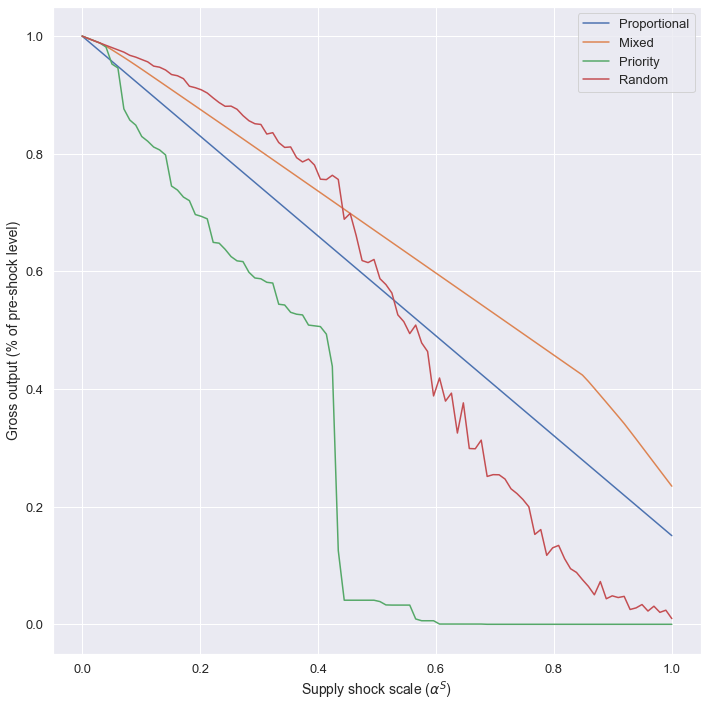

In [13]:
###### PLOT: simulating impact of supply shock size for different rationing schemes (fig 5.3)
from shockscale import shockscale
from supply_scaling import supply_scaling

sns.set_theme()

## getting data: has to be run only once (takes a very long time)
# scaling = supply_scaling(x = data_bel.x[:-1], xmax = constraints.xmax[:-1],
#                          f = constraints.c[:-1], fmax = constraints.fmax[:-1], 
#                          A = data_bel.A.iloc[:-1,:-1], L = data_bel.L.iloc[:-1,:-1], TT = 40, RUNS = 50)
# saving data as 'scaling_data'
# with open(data_path + 'scaling_data', 'w') as f:
#     json.dump(scaling, f)

# opening scaling_data
with open(data_path + 'scaling_data', 'r') as f:
    scaling = json.load(f)

prop_x, prop_f, prop_i, mixed_x, mixed_f, mixed_i, prior_x, prior_f, prior_i, random_x, random_f, random_i = scaling

## making plot
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(np.linspace(0, 1, 100), prop_x, label = 'Proportional')
ax.plot(np.linspace(0, 1, 100), mixed_x, label = 'Mixed')
ax.plot(np.linspace(0, 1, 100), prior_x, label = 'Priority')
ax.plot(np.linspace(0, 1, 100), random_x, label = 'Random')

ax.legend(loc='upper right', fontsize=13)

ax.set_xlabel(r'Supply shock scale ($\alpha^S$)', fontsize=14) # 'r' for LaTeX code
ax.set_ylabel('Gross output (% of pre-shock level)', fontsize=14)
ax.tick_params(labelsize=13)

plt.tight_layout()

plt.savefig(fig_path + 'supply_shock_scaling.png', bbox_inches='tight')

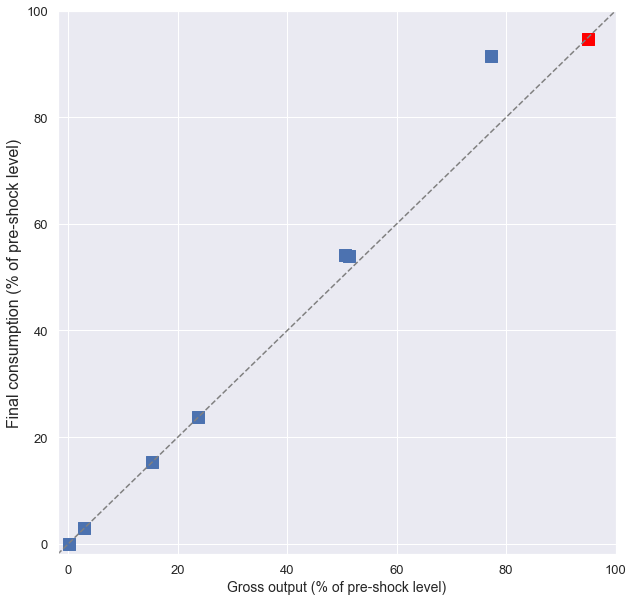

In [15]:
###### PLOT: comparing different methods (fig 5.4 + fig 5.7)
sns.set_theme()

### 1: Getting the percentage of the pre-shock values for the different methods (both for x and f)
## gross output
x0 = optimization.xvalues['x'].sum(axis=0) # total GO (for Belgium)
# optimization
LP_totx = optimization.xvalues.iloc[:,2:5].sum(axis=0)/x0
# rationing
strict_totx = strict_prop_bel.d.iloc[:,-1:].sum(axis=0)[0]/x0
mixed_totx = mixed_prop_prior_bel.d.iloc[:,-1:].sum(axis=0)[0]/x0
prior_totx = prior_bel.d.iloc[:,-1:].sum(axis=0)[0]/x0
random_totx = [None] * len(random_bel)
for i in range(len(random_bel)):
    random_totx[i] = random_bel[i].d.iloc[:,-1:].sum(axis=0)[0]/x0
random_totx = np.mean(random_totx)

totx = [LP_totx[0], LP_totx[1], LP_totx[2], strict_totx, mixed_totx, prior_totx, random_totx]

## final consumption
f0 = optimization.fvalues['f'].sum(axis=0) # total final consumption (for Belgium)
# optimization
LP_totf = optimization.fvalues.iloc[:,2:5].sum(axis=0)/f0
# rationing
strict_totf = strict_prop_bel.f.iloc[:,-1:].sum(axis=0)[0]/f0
mixed_totf = mixed_prop_prior_bel.f.iloc[:,-1:].sum(axis=0)[0]/f0
prior_totf = prior_bel.f.iloc[:,-1:].sum(axis=0)[0]/f0
random_totf = [None] * len(random_bel)
for i in range(len(random_bel)):
    random_totf[i] = random_bel[i].f.iloc[:,-1:].sum(axis=0)[0]/f0
random_totf = np.mean(random_totf)

totf = [LP_totf[0], LP_totf[1], LP_totf[2], strict_totf, mixed_totf, prior_totf, random_totf]

## All together
types = ['Direct shock', 'Maximize f', 'Maximize x', 'Proportional', 'Mixed', 'Priority', 'Random']
df_methods = pd.DataFrame(data=[types, totx, totf], index = ['type', 'x', 'f']).T

### 2. Making the plot
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x = df_methods['x']*100, y = df_methods['f']*100, s=150, marker = 's')
ax.set_xlabel('Gross output (% of pre-shock level)', fontsize=14)
ax.set_ylabel('Final consumption (% of pre-shock level)', fontsize=16)
ax.tick_params(labelsize=13)
plt.xlim([-2, 100])
plt.ylim([-2, 100])
ax.plot([-2,100], [-2,100], linestyle='dashed', color = 'grey') # add x=y

plt.savefig(fig_path + 'comparing_methods.png', bbox_inches='tight') # fig 5.4


### 3. Add actual economic impact (2020 data) --> first run code below (Real-life data)!! 
xtot_2020 = data_bel_2020.x.sum(axis=0)/x0
ftot_2020 = data_bel_2020.f.sum(axis=1).sum(axis=0)/f0

ax.scatter(x = xtot_2020*100, y = ftot_2020*100, s=150, marker='s', c = 'red')

plt.savefig(fig_path + 'comparing_methods_and_2020.png', bbox_inches='tight') # fig 5.7

In [14]:
###### Real-life data (FIGARO table from 2020)
from data_manipulation import data_manipulation 

data_2020 = pd.read_csv(data_path + 'data_FIGARO2020.csv')
data_2020.index = data_2020['rowLabels']
data_2020.drop(columns=data_2020.columns[0], axis=1, inplace=True)
data_2020 = data_2020.drop(data_2020.index[data_2020.index.str.contains('_U')]) # drop all rows _U
data_2020 = data_2020.drop(data_2020.columns[data_2020.columns.str.contains('_U')], axis=1) # drop all columns _U
country = 'BE'

data_bel_2020 = data_manipulation(country, data_2020)

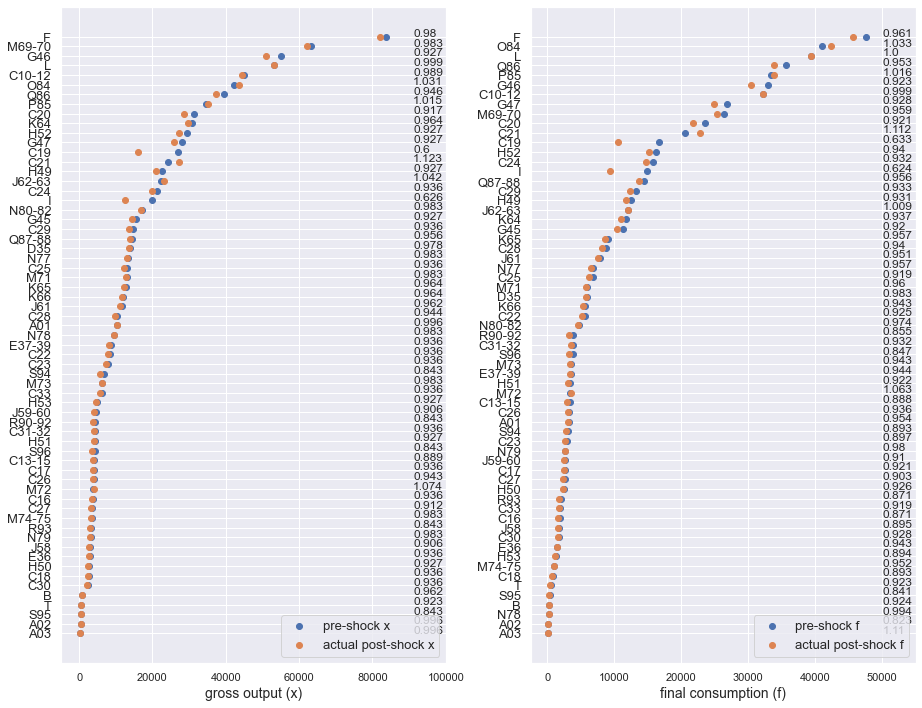

In [16]:
###### PLOT: 2019 data (pre-shock) vs 2020 data (post-shock) for each industry (x and f) with differences in percentage (fig 5.6)
sns.set_theme()

data_bel_x_ordered = data_bel.x.sort_values(ascending=False) 
data_bel_f_ordered = data_bel.f.sum(axis=1).sort_values(ascending=False)


### PLOT
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13, 10))

## ax1: gross output(x)
y_pos1 = np.arange(len(data_bel_x_ordered))
ax1.scatter(data_bel_x_ordered, y_pos1, label = 'pre-shock x')
# labels 
labels_x = [0] * len(data_bel_x_ordered)
for i in range(0, len(data_bel_x_ordered)):
    labels_x[i] = data_bel_x_ordered.index[i][3:]

ax1.set_yticks(y_pos1, labels=pd.Series(labels_x), fontsize=13)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('gross output (x)', fontsize=14)
ax1.set_xlim([-5000, 100000])
# add 2020 values + same order as data_bel_x_ordered
ax1.scatter(data_bel_2020.x.reindex(data_bel_x_ordered.index), y_pos1, label = 'actual post-shock x') 
ax1.legend(loc='lower right', fontsize=13)

# remaining percentages of pre-shock x
preshock_level_2020_x = (data_bel_2020.x/data_bel.x).reindex(data_bel_x_ordered.index)

for i, v in enumerate(preshock_level_2020_x):
    ax1.annotate(round(v,3), xy=(data_bel_x_ordered[i], y_pos1[i]), 
                xytext=(data_bel_x_ordered[62]+ 91000, y_pos1[i]))

## ax2: final consumption (f)
y_pos2 = np.arange(len(data_bel_f_ordered))
ax2.scatter(data_bel_f_ordered, y_pos2, label = 'pre-shock f')
# labels 
labels_f = [0] * len(data_bel_f_ordered)
for i in range(0, len(data_bel_f_ordered)):
    labels_f[i] = data_bel_f_ordered.index[i][3:]

ax2.set_yticks(y_pos2, labels=pd.Series(labels_f), fontsize=13)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('final consumption (f)', fontsize=14)
ax2.set_xlim([-2500, 55000])
# add 2020 values + same order as data_bel_f_ordered
ax2.scatter(data_bel_2020.f.sum(axis=1).reindex(data_bel_f_ordered.index), y_pos2, label = 'actual post-shock f') 
ax2.legend(loc = 'lower right', fontsize=13)

# remaining percentages of pre-shock f
preshock_level_2020_f = (data_bel_2020.f.sum(axis=1)/data_bel.f.sum(axis=1)).reindex(data_bel_f_ordered.index)

for i, v in enumerate(preshock_level_2020_f):
    ax2.annotate(round(v,3), xy=(data_bel_f_ordered[i], y_pos2[i]), 
                xytext=(data_bel_f_ordered[62] + 50000, y_pos2[i]))

plt.tight_layout()

plt.savefig(fig_path + '2019vs2020.png', bbox_inches='tight')


In [102]:
###### TABLE: 2019 data vs 2020 data for Belgium (x, f, VA and GDP)

print('gross output (x)')
x_bel_19 = data_bel.x.sum(axis=0)
x_bel_20 = data_bel_2020.x.sum(axis=0) 
print('2019_x ', x_bel_19)
print('2020_x ', x_bel_20)
print('x loss (in %) ', (x_bel_20-x_bel_19)/x_bel_19)
print('---------------')
print('final consumption (f)')
f_bel_19 = data_bel.f.sum(axis=1).sum(axis=0)
f_bel_20 = data_bel_2020.f.sum(axis=1).sum(axis=0)
print('2019_f ', f_bel_19)
print('2020_f ', f_bel_20)
print('f loss (in %) ', (f_bel_20-f_bel_19)/f_bel_19)
print('---------------')
print('value added (VA) ')
VA_bel_19 = dom_bel_19_tot['W2_B2A3G'] + dom_bel_19_tot['W2_D21X31']
VA_bel_20 = dom_bel_20_tot['W2_B2A3G'] + dom_bel_20_tot['W2_D21X31']
print('2019_VA ', VA_bel_19)
print('2020_VA ', VA_bel_20)
print('VA loss (in %) ', (VA_bel_20-VA_bel_19)/VA_bel_19)
print('---------------')
print('gross domestic product (GDP)')
GDP_bel_19 = dom_bel_19_tot['W2_D1'] + dom_bel_19_tot['W2_D29X39'] + dom_bel_19_tot['W2_B2A3G'] + dom_bel_19_tot['W2_D21X31']
GDP_bel_20 = dom_bel_20_tot['W2_D1'] + dom_bel_20_tot['W2_D29X39'] + dom_bel_20_tot['W2_B2A3G'] + dom_bel_20_tot['W2_D21X31']
print('2019_GDP ', GDP_bel_19)
print('2020_GDP ', GDP_bel_20)
print('GDP loss (in %) ', (GDP_bel_20-GDP_bel_19)/GDP_bel_19)
print('---------------')

gross output (x)
2019_x  974820.135000002
2020_x  926454.161000002
x loss (in %)  -0.04961528005368903
---------------
final consumption (f)
2019_f  634473.5760000002
2020_f  601061.415
f loss (in %)  -0.05266123328672743
---------------
value added (VA) 
2019_VA  247205.734
2020_VA  234931.73200000002
VA loss (in %)  -0.04965095995710188
---------------
gross domestic product 
2019_GDP  478165.975
2020_GDP  456892.83400000003
GDP loss (in %)  -0.04448903124066899
---------------
